<a href="https://colab.research.google.com/github/arutraj/ML_Basics/blob/main/Forecasting_Web_Traffic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Web Traffic Forecasting

(This notebook will help you understand how to formulate and build a deep learning model for time series data.)


## Understanding the Problem Statement
In order to dynamically manage resources to run your website, you need to have an idea about the number of visitors who might arrive at your website at different points in time. So, the problem at hand is to predict the web traffic or number of sessions in the next hour based on the historical data.

## Load Dataset

Let us load the dataset first.

In [1]:
import pandas as pd
import numpy as np

data=pd.read_csv('/content/webtraffic.csv')

Check the shape of the data

In [2]:
data.shape

(4896, 2)

Take a glance at the first 5 rows

In [3]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


## Data Exploration

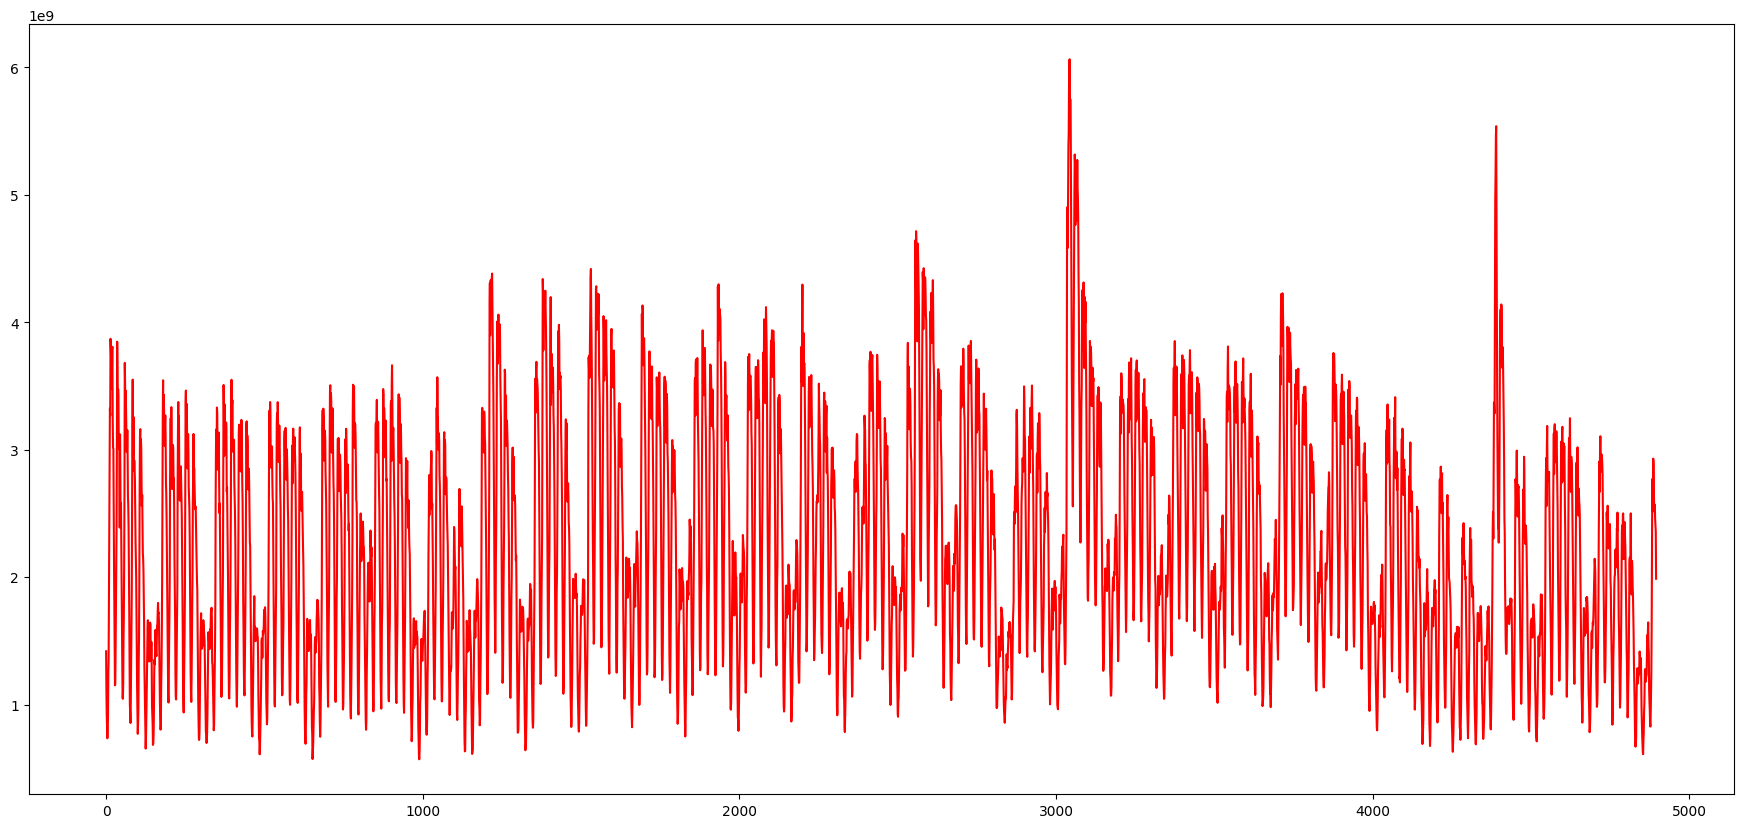

In [4]:
import matplotlib.pyplot as plt
sessions = data['Sessions'].values

ar = np.arange(len(sessions))
plt.figure(figsize=(22,10))
plt.plot(ar, sessions,'r')
plt.show()

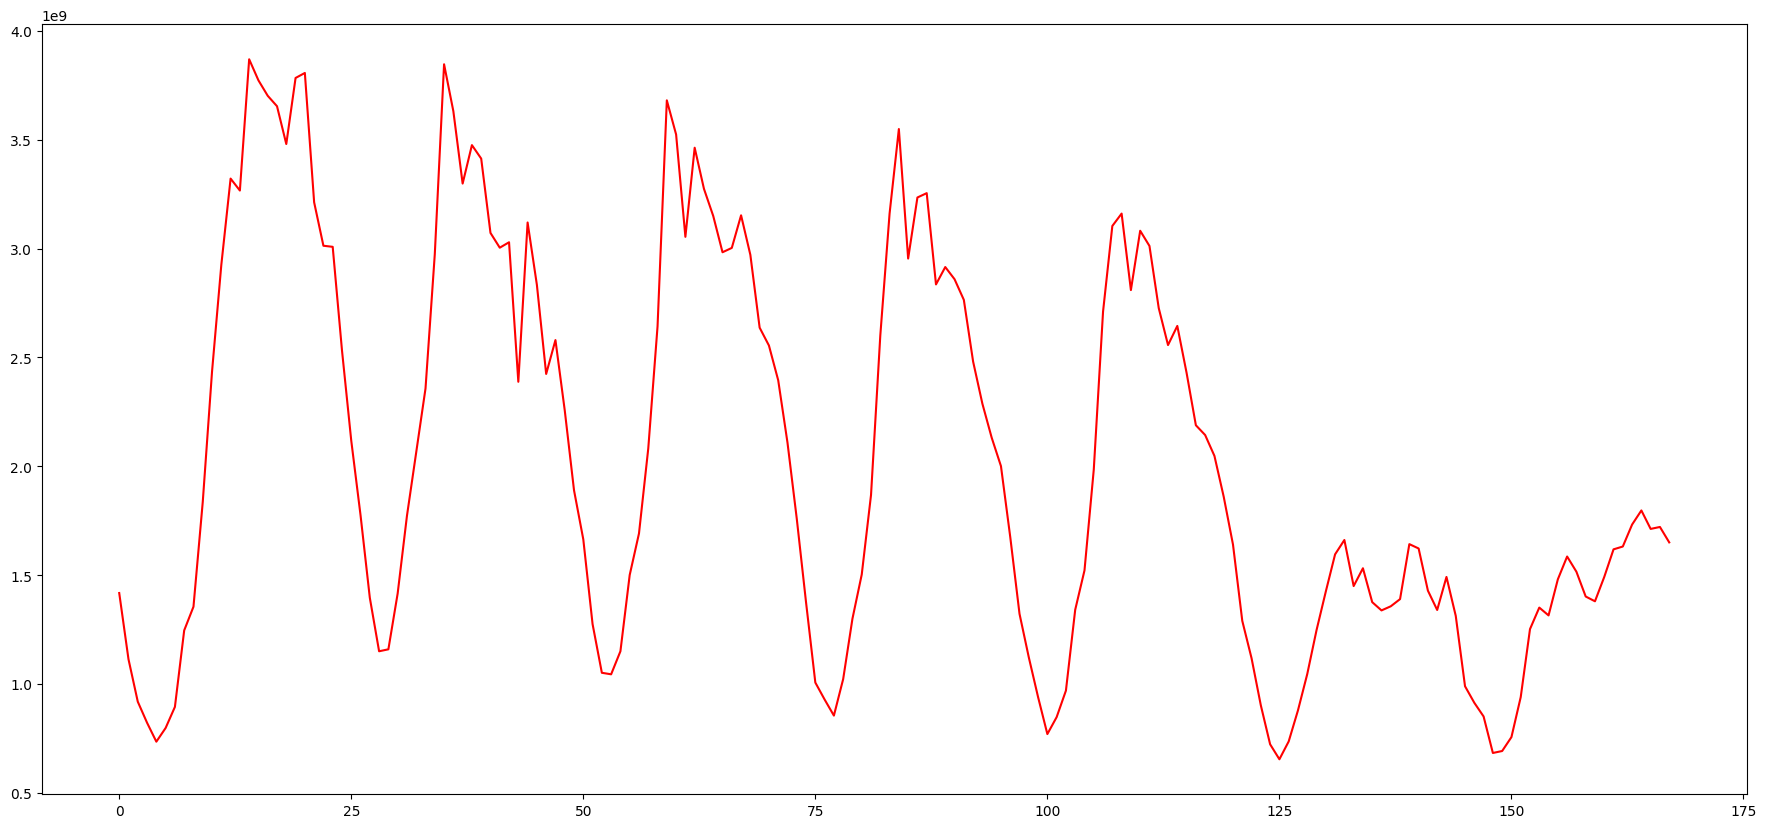

In [5]:
#first week web traffic
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22,10))
plt.plot(ar, sample,'r')
plt.show()

## Data Preparation

We will model the problem to predict the traffic for the next hour based on the previous week data i.e. 168 hours. Lets define a function to prepare the input and output data accordingly.

*Note: The input is a sequence of values and the output is a single value.*

In [6]:
def prepare_data(seq,num):
  x=[]
  y=[]

  for i in range(0,(len(seq)-num),1):

    input_ = seq[i:i+num]
    output  = seq[i+num]

    x.append(input_)
    y.append(output)

  return np.array(x), np.array(y)

Call the function

In [7]:
num=168
x,y= prepare_data(sessions,num)

In [8]:
print(len(x))

4728


No. of input sequences is around 4700

In [9]:
x[0]

array([1418159421, 1113769116,  919158921,  822352824,  735526737,
        798400800,  895206897, 1246503249, 1355285358, 1836321840,
       2435122440, 2925140931, 3321347328, 3266457273, 3869249877,
       3772443780, 3701585709, 3653681661, 3480029487, 3783421791,
       3806375814, 3212565219, 3012965019, 3007975014, 2532926538,
       2117758122, 1775443779, 1396203399, 1150695153, 1159677162,
       1416163419, 1772449776, 2063866068, 2357278362, 2974042980,
       3846295854, 3630727638, 3298393305, 3475039482, 3413163420,
       3071847078, 3003983010, 3028933035, 2388216393, 3119751126,
       2833324839, 2424144429, 2579832585, 2257478262, 1890213894,
       1664665668, 1275445278, 1051893054, 1044907047, 1150695153,
       1500993504, 1691611695, 2081830086, 2642706648, 3680627688,
       3523941531, 3053883060, 3463063470, 3274441281, 3149691156,
       2983024989, 3002985009, 3152685159, 2971048977, 2636718642,
       2554882560, 2395202400, 2108776113, 1759475763, 1375245

In [10]:
y[0]

1427141430

Split the dataset into training and validation data

In [11]:
ind = int(0.9 * len(x))

x_tr = x[:ind]
y_tr = y[:ind]

x_val=x[ind:]
y_val=y[ind:]

Normalize the input and output data as it speeds up the training process




In [12]:
from sklearn.preprocessing import StandardScaler

#normalize the inputs
x_scaler= StandardScaler()
x_tr = x_scaler.fit_transform(x_tr)
x_val= x_scaler.transform(x_val)

#reshaping the output for normalization
y_tr=y_tr.reshape(len(y_tr),1)
y_val=y_val.reshape(len(y_val),1)

#normalize the output
y_scaler=StandardScaler()
y_tr = y_scaler.fit_transform(y_tr)[:,0]
y_val = y_scaler.transform(y_val)[:,0]

In [13]:
print(x_tr.shape)

(4255, 168)


As you can see here, the input data is a 2 dimenional array but the LSTM and Conv1D accepts only 3 dimensional inputs in the form of (no. of samples, no. of timesteps, no. of features)

So, reshaping the input data as per the model requirement

In [14]:
#reshaping input data
x_tr= x_tr.reshape(x_tr.shape[0],x_tr.shape[1],1)
x_val= x_val.reshape(x_val.shape[0],x_val.shape[1],1)

In [15]:
print(x_tr.shape)

(4255, 168, 1)


Now, the data is ready for model training.

<br>

## Model Building

Define the model architecture

In [16]:
from keras.models import *
from keras.layers import *
from keras.callbacks import *

model= Sequential()

model.add(Conv1D(64, 3, padding='same', activation='relu',input_shape=(num,1)))

model.add(Conv1D(32, 5, padding='same', activation='relu',input_shape=(num,1)))

model.add(Flatten())

model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='linear'))

Understand the output shape and no. of parameters of each layer

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 64)           256       
                                                                 
 conv1d_1 (Conv1D)           (None, 168, 32)           10272     
                                                                 
 flatten (Flatten)           (None, 5376)              0         
                                                                 
 dense (Dense)               (None, 64)                344128    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 354721 (1.35 MB)
Trainable params: 354721 (1.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Define the optimizer and loss:

In [18]:
model.compile(loss='mse',optimizer='adam')

Define the callback to save the best model during the training

In [19]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Train the model for 30 epochs with batch size of 32:

In [20]:
history=model.fit(x_tr, y_tr ,epochs=30, batch_size=32, validation_data=(x_val,y_val), callbacks=[mc])

Epoch 1/30
130/133 [============================>.] - ETA: 0s - loss: 0.1082
Epoch 1: val_loss improved from inf to 0.05485, saving model to best_model.hdf5
133/133 [==============================] - 4s 19ms/step - loss: 0.1072 - val_loss: 0.0549
Epoch 2/30
  3/133 [..............................] - ETA: 3s - loss: 0.0471

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - ETA: 0s - loss: 0.0293
Epoch 2: val_loss improved from 0.05485 to 0.04334, saving model to best_model.hdf5
133/133 [==============================] - 4s 27ms/step - loss: 0.0293 - val_loss: 0.0433
Epoch 3/30
130/133 [============================>.] - ETA: 0s - loss: 0.0192
Epoch 3: val_loss improved from 0.04334 to 0.02515, saving model to best_model.hdf5
133/133 [==============================] - 2s 18ms/step - loss: 0.0193 - val_loss: 0.0252
Epoch 4/30
131/133 [============================>.] - ETA: 0s - loss: 0.0168
Epoch 4: val_loss improved from 0.02515 to 0.02265, saving model to best_model.hdf5
133/133 [==============================] - 2s 17ms/step - loss: 0.0170 - val_loss: 0.0227
Epoch 5/30
131/133 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 5: val_loss improved from 0.02265 to 0.02173, saving model to best_model.hdf5
133/133 [==============================] - 2s 17ms/step - loss: 0.0143 - val_loss: 0.0217
Epoch 6

Load the weights of best model prior to predictions

In [21]:
model.load_weights('best_model.hdf5')

Evaluate the performance of model on the validation data

In [22]:
mse = model.evaluate(x_val,y_val)
print("Mean Square Error:",mse)

15/15 [==============================] - 0s 5ms/step - loss: 0.0166
Mean Square Error: 0.016632555052638054


## Comparision with the baseline model

In [23]:
#build a simple model
def compute_moving_average(data):
  pred=[]
  for i in data:
    avg=np.sum(i)/len(i)
    pred.append(avg)
  return np.array(pred)

In [24]:
x_reshaped = x_val.reshape(-1,168)
y_pred = compute_moving_average(x_reshaped)

In [25]:
mse = np.sum ( (y_val - y_pred) **2 ) / (len(y_val))
print(mse)

0.5546025834434455


## Forecasting

**Steps to Follow**:

1. Intialize the array, say "data" with a weeks data
2. Predict for the next hour
3. Append the predicted value as the last element of array "data"
4. Skip the first element of array "data"
5. Repeat steps 2 to 4 for **N** iterations

Define a function which forecasts the traffic for the next hours from the previous week data.

In [26]:
def forecast(x_val, no_of_pred, ind):
  predictions=[]

  #intialize the array with previous weeks data
  temp=x_val[ind]

  for i in range(no_of_pred):

    #predict for the next hour
    pred=model.predict(temp.reshape(1,-1,1))[0][0]

    #append the prediction as the last element of array
    temp = np.insert(temp,len(temp),pred)
    predictions.append(pred)

    #ignore the first element of array
    temp = temp[1:]

  return predictions

Its time to forecast the traffic for the next 24 hours based on the previous week data

In [27]:
no_of_pred =24
ind=72
y_pred= forecast(x_val,no_of_pred,ind)

1/1 [==============================] - 0s 19ms/step


In [28]:
y_true = y_val[ind:ind+(no_of_pred)]

Lets convert back the normalized values to the original dimensional space

In [29]:
y_true= y_scaler.inverse_transform(y_true.reshape(-1, 1))
y_pred= y_scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))

In [30]:
def plot(y_true,y_pred):
  ar = np.arange(len(y_true))
  plt.figure(figsize=(22,10))
  plt.plot(ar, y_true,'r')
  plt.plot(ar, y_pred,'y')
  plt.show()

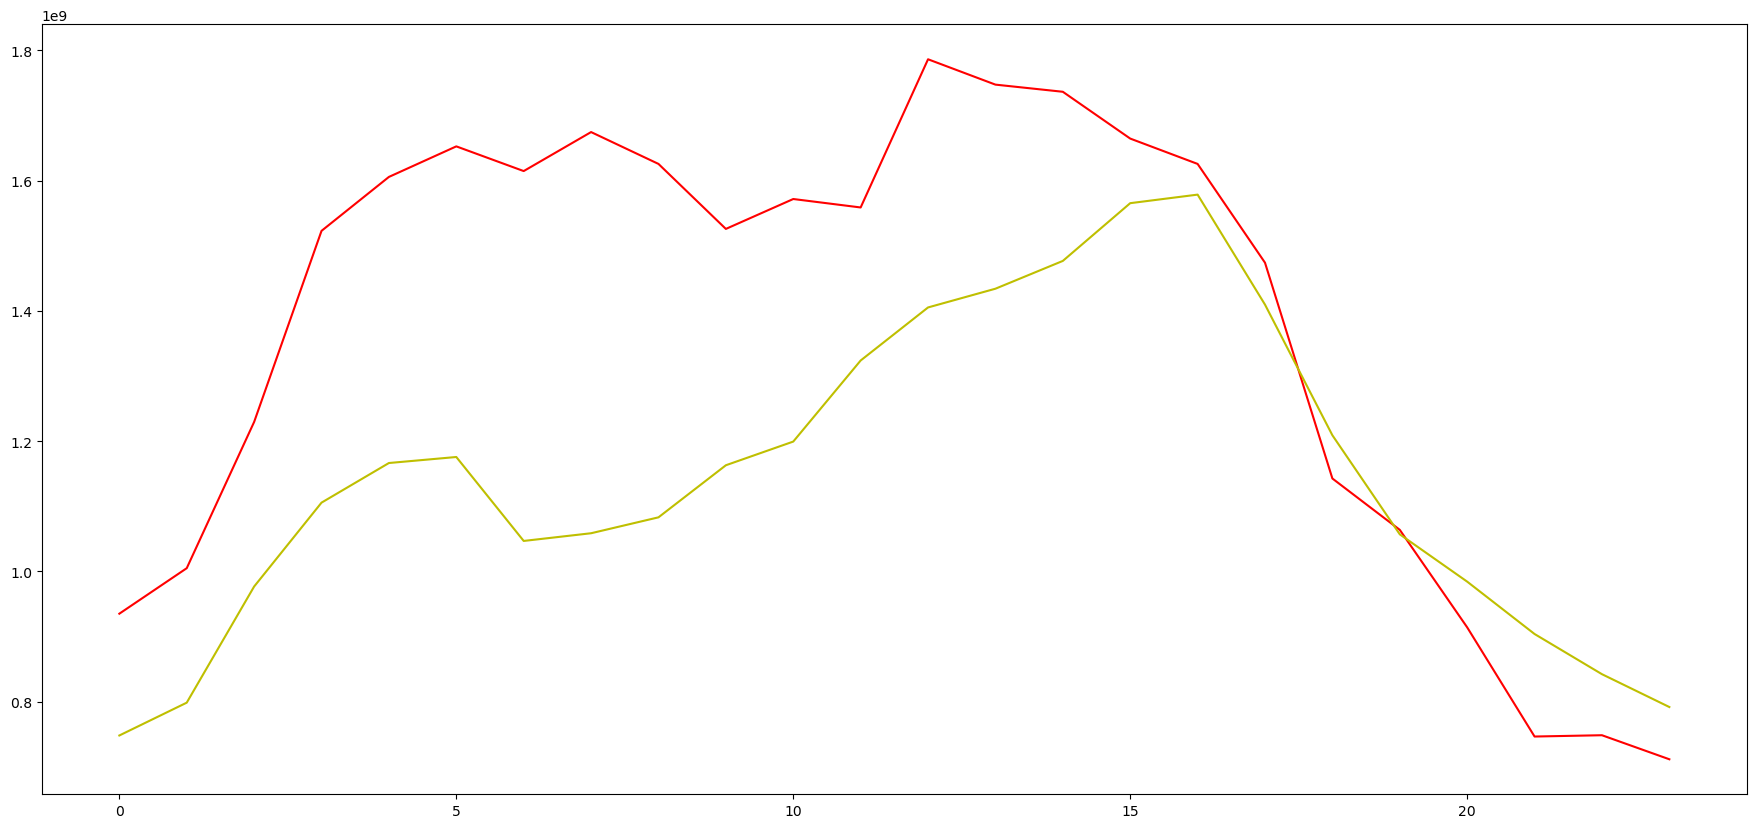

In [ ]:
plot(y_true,y_pred)

Wow, Thats Amazing. The forecasted values are almost close to the actual values.

## How to improve the Model Performance?

1. We can make the time series data stationary
2. Try different number of hidden units
3. Change the learning rate